In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import keras

# import keras
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

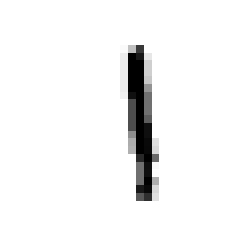

1


In [21]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

i = 8
plt.imshow(x_train[i,:], cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
print(y_train[i])

In [22]:
# Flatten the images

image_vector_size = 28*28

X_train = x_train.reshape(x_train.shape[0],image_vector_size)

X_test = x_test.reshape( x_test.shape[0],image_vector_size)
X_train=X_train.T
X_test=X_test.T
# scale
X_train = X_train / 255
X_test = X_test/ 255


# one-hot encode labels
# Convert to "one-hot" vectors using the to_categorical function

num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
Y_train=y_train.T

y_test = keras.utils.to_categorical(y_test, num_classes)
y_test=y_test.T
Y_test=y_test

# split, reshape, shuffle
m = 60000
#m_test = X.shape[0] - m
shuffle_index = np.random.permutation(m)
X_train, Y_train = X_train[:, shuffle_index], Y_train[:, shuffle_index]

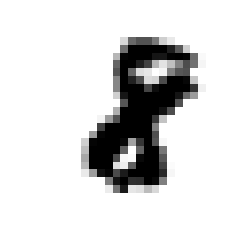

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [23]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

i = 8
plt.imshow(X_train[:,i].reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
print(Y_train[:,i])

In [26]:

def sigmoid(z):
    s = 1. / (1. + np.exp(-z))
    return s

def compute_loss(Y, Y_hat):

    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1./m) * L_sum

    return L

def feed_forward(X, params,drop_p):

    cache = {}

    cache["Z1"] = np.matmul(params["W1"], X) + params["b1"]
    cache["A1"] = sigmoid(cache["Z1"])
    #keep_prob=1-drop_p
    #D1 = np.random.rand(cache["A1"].shape[0], cache["A1"].shape[1])                               # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    #D1 = D1 < keep_prob                                         # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    #cache["A1"] = np.multiply(cache["A1"], D1)                                         # Step 3: shut down some neurons of A1
    #cache["A1"] = cache["A1"]/keep_prob   
    #cache["D1"] = D1
    cache["Z2"] = np.matmul(params["W2"], cache["A1"]) + params["b2"]
    cache["A2"] = np.exp(cache["Z2"]) / np.sum(np.exp(cache["Z2"]), axis=0)

    return cache

def back_propagate(X, Y, params, cache,drop_p):

    dZ2 = cache["A2"] - Y
    dW2 = (1./m_batch) * np.matmul(dZ2, cache["A1"].T)
    db2 = (1./m_batch) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.matmul(params["W2"].T, dZ2)
    #keep_prob=1-drop_p
    #dA1= np.multiply(cache["D1"],dA1)
    #dA1 = dA1/keep_prob
    dZ1 = dA1 * sigmoid(cache["Z1"]) * (1 - sigmoid(cache["Z1"]))
    dW1 = (1./m_batch) * np.matmul(dZ1, X.T)
    db1 = (1./m_batch) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return grads



In [27]:

np.random.seed(138)
digits=10;
# hyperparameters
n_x = X_train.shape[0]
n_h = 64
learning_rate = 4
beta = 0.9
batch_size = 128
batches = -(-m // batch_size)
drop_p=0.5

# initialization
params = { "W1": np.random.randn(n_h, n_x) * np.sqrt(1. / n_x),
           "b1": np.zeros((n_h, 1)) * np.sqrt(1. / n_x),
           "W2": np.random.randn(digits, n_h) * np.sqrt(1. / n_h),
           "b2": np.zeros((digits, 1)) * np.sqrt(1. / n_h) }

V_dW1 = np.zeros(params["W1"].shape)
V_db1 = np.zeros(params["b1"].shape)
V_dW2 = np.zeros(params["W2"].shape)
V_db2 = np.zeros(params["b2"].shape)

prev_tcost=1000;
# train
for i in range(100):

    permutation = np.random.permutation(X_train.shape[1])
    X_train_shuffled = X_train[:, permutation]
    Y_train_shuffled = Y_train[:, permutation]

    for j in range(batches):

        begin = j * batch_size
        end = min(begin + batch_size, X_train.shape[1] - 1)
        X = X_train_shuffled[:, begin:end]
        Y = Y_train_shuffled[:, begin:end]
        m_batch = end - begin

        cache = feed_forward(X, params,drop_p)
        grads = back_propagate(X, Y, params, cache,drop_p)

        V_dW1 = (beta * V_dW1 + (1. - beta) * grads["dW1"])
        V_db1 = (beta * V_db1 + (1. - beta) * grads["db1"])
        V_dW2 = (beta * V_dW2 + (1. - beta) * grads["dW2"])
        V_db2 = (beta * V_db2 + (1. - beta) * grads["db2"])

        params["W1"] = params["W1"] - learning_rate * V_dW1
        params["b1"] = params["b1"] - learning_rate * V_db1
        params["W2"] = params["W2"] - learning_rate * V_dW2
        params["b2"] = params["b2"] - learning_rate * V_db2

    cache = feed_forward(X_train, params,drop_p)
    train_cost = compute_loss(Y_train, cache["A2"])
    cache = feed_forward(X_test, params,0.0)
    test_cost = compute_loss(Y_test, cache["A2"])
    #if((prev_tcost+0.01)<test_cost):
    #    break;
    #else:
    #    prev_tcost=test_cost
    print("Epoch {}: training cost = {}, test cost = {}".format(i+1 ,train_cost, test_cost))

print("Done.")

Epoch 1: training cost = 0.1557111511071778, test cost = 0.16695714193366465
Epoch 2: training cost = 0.10092936073593455, test cost = 0.11760574469284768
Epoch 3: training cost = 0.0806483930222924, test cost = 0.10210363241511437
Epoch 4: training cost = 0.06818503106233023, test cost = 0.10215030083919488
Epoch 5: training cost = 0.059403118954138544, test cost = 0.0997087884486664
Epoch 6: training cost = 0.043732593499217244, test cost = 0.0931807548622698
Epoch 7: training cost = 0.03915062730444597, test cost = 0.09326284544354708
Epoch 8: training cost = 0.034101018883718234, test cost = 0.08950138292981233
Epoch 9: training cost = 0.03419568745575665, test cost = 0.09364669318744087
Epoch 10: training cost = 0.02630328043497226, test cost = 0.0891818202006092
Epoch 11: training cost = 0.022091965141241947, test cost = 0.08997185223175606
Epoch 12: training cost = 0.019193324323089917, test cost = 0.08776972817211459
Epoch 13: training cost = 0.017442822687971853, test cost = 0

In [28]:
cache = feed_forward(X_test, params,0.0)
predictions = np.argmax(cache["A2"], axis=0)
labels = np.argmax(Y_test, axis=0)

print(classification_report(predictions, labels))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       987
           1       0.99      0.99      0.99      1137
           2       0.97      0.98      0.97      1020
           3       0.98      0.96      0.97      1028
           4       0.98      0.98      0.98       981
           5       0.97      0.97      0.97       887
           6       0.98      0.98      0.98       957
           7       0.97      0.97      0.97      1035
           8       0.97      0.98      0.97       967
           9       0.97      0.97      0.97      1001

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

